In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import PSS_analyzer as pssa
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


annots_path = {
    'train' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/data/DCM/magi/train.json',
    'val' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/data/DCM/magi/val.json',
    'test' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/data/DCM/magi/test.json'
}

img_path = '/home-local/mserrao/PSSComics/multimodal-comic-pss/datasets.unify/DCM/images'

splits = {
    'train': '/home-local/mserrao/PSSComics/multimodal-comic-pss/datasets.unify/DCM/splits/train.csv',
    'val' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/datasets.unify/DCM/splits/val.csv',
    'test' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/datasets.unify/DCM/splits/test.csv'
}

GT_path = {
    'train' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/EncoderClassifier/data/comics_train.json',
    'val' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/EncoderClassifier/data/comics_val.json',
    'test' : '/home-local/mserrao/PSSComics/multimodal-comic-pss/EncoderClassifier/data/comics_test.json'
}

CLS_MAPPING = {
    1: 'Panel',
    2: 'Character',
    4: 'Text',
    7: 'Face'
}

In [2]:
def load_annots(path):
    with open(path, 'r') as f:
        data = json.load(f)
    
    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])
    
    unique_image_ids = annotations_df['image_id'].unique()
    image_id_to_page = {img_id: page_num for page_num, img_id in enumerate(unique_image_ids, start=1)}

    annotations_df['page_number'] = annotations_df['image_id'].map(image_id_to_page)
    
    return images_df, annotations_df

def load_GT(path):
    with open(path, 'r') as f:
        data = json.load(f)
        
    return data

In [3]:
GT_data = load_GT(GT_path['train'])

In [4]:
results = pssa.analyze_comic_book(annots_path['train'], plot=False)

In [5]:
page_stats = results['page_stats']
annots_df = results['annotations']
imgs_df = results['images']

display(page_stats, imgs_df, annots_df)

,page_number,category_id,page_number_book,bbox_max_dim_max,bbox_max_dim_mean,area_max,area_mean,bbox_count
0,0,1,10,622.137152,470.280935,2.808585e+05,1.684311e+05,6
1,0,2,10,346.430840,285.579688,1.125731e+05,5.111880e+04,14
2,0,4,10,222.564979,151.548991,2.157822e+04,1.178140e+04,13
3,1,1,29,1253.669985,1253.669985,1.123165e+06,1.123165e+06,1
4,1,4,29,1031.590120,612.963349,4.264535e+05,2.229635e+05,3
...,...,...,...,...,...,...,...,...
43050,14554,2,78,696.494504,373.340715,4.225385e+05,1.077347e+05,27
43051,14554,4,78,1582.175734,358.405620,2.367370e+05,5.692257e+04,13
43052,14555,1,54,1619.376060,966.704110,1.290953e+06,7.331682e+05,5
43053,14555,2,54,682.837221,331.823512,3.917239e+05,8.843725e+04,30


,id,width,height,file_name,book_hash,page_number,page_number_book
0,29165896400010,1015,1393,add7a048/010.jpg,add7a048,0,10
1,29165896400029,900,1257,add7a048/029.jpg,add7a048,1,29
2,29165896400033,1050,1422,add7a048/033.jpg,add7a048,2,33
3,29165896400013,1005,1407,add7a048/013.jpg,add7a048,3,13
4,29165896400044,1036,1413,add7a048/044.jpg,add7a048,4,44
...,...,...,...,...,...,...,...
14551,39686570670008,1680,2306,ec8ce6ab/008.jpg,ec8ce6ab,14551,8
14552,39686570670038,1680,2303,ec8ce6ab/038.jpg,ec8ce6ab,14552,38
14553,39686570670091,1680,2299,ec8ce6ab/091.jpg,ec8ce6ab,14553,91
14554,39686570670078,1680,2298,ec8ce6ab/078.jpg,ec8ce6ab,14554,78


,id,image_id,category_id,bbox,area,iscrowd,score,book_hash,page_number,page_number_book,bbox_max_dim
0,1,29165896400010,2,"[239.0382584245007, 620.9763472278202, 162.546...",41190.201658,0,0.811465,add7a048,0,10,253.405756
1,2,29165896400010,2,"[625.3315324680779, 227.47716031355543, 120.48...",30097.553249,0,0.625297,add7a048,0,10,249.811093
2,3,29165896400010,2,"[846.9281882598178, 954.1955638577363, 122.675...",38344.014086,0,0.533259,add7a048,0,10,312.565681
3,4,29165896400010,2,"[625.2910860333523, 227.0579896616949, 121.707...",30628.180936,0,0.372202,add7a048,0,10,251.653753
4,5,29165896400010,2,"[717.4985039907938, 217.63471835751787, 161.40...",41526.445605,0,0.919790,add7a048,0,10,257.281500
...,...,...,...,...,...,...,...,...,...,...,...
461288,461289,39686570670054,4,"[1246.0380641284119, 878.210298854603, 387.420...",72292.792732,0,0.261700,ec8ce6ab,14555,54,387.420001
461289,461290,39686570670054,4,"[50.195199920679535, 843.8472350143348, 743.47...",67849.250911,0,0.427663,ec8ce6ab,14555,54,743.479987
461290,461291,39686570670054,4,"[383.3342703163772, 911.6555406544936, 427.877...",73660.618180,0,0.263287,ec8ce6ab,14555,54,427.877499
461291,461292,39686570670054,4,"[901.2171490513854, 1583.7996654937865, 687.17...",88704.583780,0,0.481798,ec8ce6ab,14555,54,687.173146


In [6]:
advanced_features = pssa.calculate_advanced_features(annots_df, imgs_df)

In [7]:
advanced_features

,image_id,book_hash,page_number,page_number_book,page_width,page_height,page_area,panel_count,character_count,text_count,...,total_character_area,total_text_area,total_face_area,max_panel_centroid_x,max_panel_centroid_y,panel_coverage,text_to_panel_ratio,character_to_text_ratio,max_text_centroid_x,max_text_centroid_y
0,29165896400010,add7a048,0,10,1015,1393,1413895,6,14,13,...,7.156632e+05,153158.236248,0,0.656444,0.812624,0.714754,0.151554,4.672704,0.760299,0.696673
1,29165896400029,add7a048,1,29,900,1257,1131300,1,0,3,...,0.000000e+00,668890.470728,0,0.499415,0.487341,0.992809,0.595541,0.000000,0.285136,0.535338
2,29165896400033,add7a048,2,33,1050,1422,1493100,5,8,4,...,3.207928e+05,75726.771253,0,0.505872,0.761459,0.804797,0.063019,4.236187,0.280413,0.600646
3,29165896400013,add7a048,3,13,1005,1407,1414035,1,3,1,...,1.853583e+06,37257.417969,0,0.514935,0.496582,0.931409,0.028289,49.750698,0.402537,0.885681
4,29165896400044,add7a048,4,44,1036,1413,1463868,6,15,11,...,7.973904e+05,129548.439855,0,0.732347,0.790848,0.833751,0.106144,6.155153,0.244183,0.078629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14551,39686570670008,ec8ce6ab,14551,8,1680,2306,3874080,7,11,16,...,1.456039e+06,881496.991716,0,0.262167,0.505239,0.890216,0.255598,1.651780,0.183072,0.732784
14552,39686570670038,ec8ce6ab,14552,38,1680,2303,3869040,5,18,15,...,2.011954e+06,727924.379002,0,0.498332,0.350647,1.236405,0.152168,2.763960,0.333487,0.768299
14553,39686570670091,ec8ce6ab,14553,91,1680,2299,3862320,6,22,10,...,2.570641e+06,356462.670660,0,0.320502,0.177923,0.915275,0.100836,7.211530,0.830224,0.418292
14554,39686570670078,ec8ce6ab,14554,78,1680,2298,3860640,4,27,13,...,2.908837e+06,739993.434221,0,0.705106,0.628110,0.763418,0.251077,3.930896,0.502224,0.941987


### 1. **Panel-Related Features**:
   - **Panel_bbox_max_dim_max**: Maximum of the maximum bounding box dimensions across panels.
   - **Panel_bbox_max_dim_mean**: Mean of the maximum bounding box dimensions across panels.
   - **Panel_area_max**: Maximum area of the panels.
   - **Panel_area_mean**: Mean area of the panels.
   - **Panel_bbox_count**: Number of bounding boxes (panels) on the page.
   - **max_panel_centroid_x**: Maximum x-coordinate of the panel centroids.
   - **max_panel_centroid_y**: Maximum y-coordinate of the panel centroids.
   - **panel_coverage**: Coverage of the page by panels (likely a ratio of panel area to page area).

### 2. **Character-Related Features**:
   - **Character_bbox_max_dim_max**: Maximum of the maximum bounding box dimensions across characters.
   - **Character_bbox_max_dim_mean**: Mean of the maximum bounding box dimensions across characters.
   - **total_character_area**: Total area covered by character bounding boxes.
   - **character_to_text_ratio**: Ratio of character area to text area.

### 3. **Text-Related Features**:
   - **total_text_area**: Total area covered by text bounding boxes.
   - **text_to_panel_ratio**: Ratio of text area to panel area.
   - **max_text_centroid_x**: Maximum x-coordinate of the text centroids.
   - **max_text_centroid_y**: Maximum y-coordinate of the text centroids.

### 4. **Face-Related Features**:
   - **total_face_area**: Total area covered by face bounding boxes (if any).

### 5. **Page-Level Features**:
   - **page_number**: The page number within the book.
   - **page_number_book**: The page number within the entire book.
   - **page_type**: Type of page (e.g., "story").

### 6. **Derived Ratios and Metrics**:
   - **text_to_panel_ratio**: Ratio of text area to panel area.
   - **character_to_text_ratio**: Ratio of character area to text area.
   - **panel_coverage**: Coverage of the page by panels.

### 7. **Centroid Features**:
   - **max_panel_centroid_x**: Maximum x-coordinate of the panel centroids.
   - **max_panel_centroid_y**: Maximum y-coordinate of the panel centroids.
   - **max_text_centroid_x**: Maximum x-coordinate of the text centroids.
   - **max_text_centroid_y**: Maximum y-coordinate of the text centroids.

In [8]:
# def add_page_type_annotations(page_stats, annotations_df, gt_data):
#     page_type_map = {}
    
#     for book in gt_data:
#         book_hash = book["hash_code"]
        
#         for story in book.get("stories", []):
#             for page in range(story["page_start"], story["page_end"] + 1):
#                 page_type_map[(book_hash, page)] = "story"
        
#         for textstory in book.get("textstories", []):
#             for page in range(textstory["page_start"], textstory["page_end"] + 1):
#                 page_type_map[(book_hash, page)] = "textstory"
        
#         for ad in book.get("advertisements", []):
#             for page in range(ad["page_start"], ad["page_end"] + 1):
#                 page_type_map[(book_hash, page)] = "advertisement"
        
#         for cover in book.get("covers", []):
#             for page in range(cover["page_start"], cover["page_end"] + 1):
#                 page_type_map[(book_hash, page)] = "cover"
    
#     image_to_type = {}
#     for _, row in annotations_df[['page_number', 'book_hash', 'page_number_book']].iterrows():
#         book_hash = row['book_hash']
#         page_num = row['page_number_book']  
#         page_type = page_type_map.get((book_hash, page_num), "unknown")
#         image_to_type[row['page_number']] = page_type
    
#     page_stats['page_type'] = page_stats['page_number'].map(image_to_type)
    
#     return page_stats

In [9]:
def add_page_type_annotations(page_stats, annotations_df, gt_data):
    page_type_map = {}
    first_page_story_map = {}  # Track first pages of stories
    
    for book in gt_data:
        book_hash = book["hash_code"]
        
        # Mark story pages and identify first pages
        for story in book.get("stories", []):
            first_page = story["page_start"]  # First page of this story
            first_page_story_map[(book_hash, first_page)] = True
            
            for page in range(story["page_start"], story["page_end"] + 1):
                page_type_map[(book_hash, page)] = "story"
        
        for textstory in book.get("textstories", []):
            for page in range(textstory["page_start"], textstory["page_end"] + 1):
                page_type_map[(book_hash, page)] = "textstory"
        
        for ad in book.get("advertisements", []):
            for page in range(ad["page_start"], ad["page_end"] + 1):
                page_type_map[(book_hash, page)] = "advertisement"
        
        for cover in book.get("covers", []):
            for page in range(cover["page_start"], cover["page_end"] + 1):
                page_type_map[(book_hash, page)] = "cover"
    
    image_to_type = {}
    for _, row in annotations_df[['page_number', 'book_hash', 'page_number_book']].iterrows():
        book_hash = row['book_hash']
        page_num = row['page_number_book']  
        
        # Check if this is a first page of a story
        if first_page_story_map.get((book_hash, page_num), False):
            image_to_type[row['page_number']] = "story_first_page"
        else:
            page_type = page_type_map.get((book_hash, page_num), "unknown")
            image_to_type[row['page_number']] = page_type
    
    page_stats['page_type'] = page_stats['page_number'].map(image_to_type)
    
    return page_stats

In [10]:
page_stats = add_page_type_annotations(page_stats, annots_df, GT_data)

In [11]:
page_stats['page_type'].value_counts()

page_type
story               30738
story_first_page     5791
advertisement        3642
textstory            1407
cover                 982
unknown               495
Name: count, dtype: int64

In [12]:
page_stats

,page_number,category_id,page_number_book,bbox_max_dim_max,bbox_max_dim_mean,area_max,area_mean,bbox_count,page_type
0,0,1,10,622.137152,470.280935,2.808585e+05,1.684311e+05,6,story
1,0,2,10,346.430840,285.579688,1.125731e+05,5.111880e+04,14,story
2,0,4,10,222.564979,151.548991,2.157822e+04,1.178140e+04,13,story
3,1,1,29,1253.669985,1253.669985,1.123165e+06,1.123165e+06,1,textstory
4,1,4,29,1031.590120,612.963349,4.264535e+05,2.229635e+05,3,textstory
...,...,...,...,...,...,...,...,...,...
43050,14554,2,78,696.494504,373.340715,4.225385e+05,1.077347e+05,27,story
43051,14554,4,78,1582.175734,358.405620,2.367370e+05,5.692257e+04,13,story
43052,14555,1,54,1619.376060,966.704110,1.290953e+06,7.331682e+05,5,story
43053,14555,2,54,682.837221,331.823512,3.917239e+05,8.843725e+04,30,story


In [13]:
page_to_book = annots_df[['page_number', 'book_hash']].drop_duplicates().set_index('page_number')['book_hash']
    
page_stats['book_hash'] = page_stats['page_number'].map(page_to_book)

display(page_stats.head())

,page_number,category_id,page_number_book,bbox_max_dim_max,bbox_max_dim_mean,area_max,area_mean,bbox_count,page_type,book_hash
0,0,1,10,622.137152,470.280935,2.808585e+05,1.684311e+05,6,story,add7a048
1,0,2,10,346.430840,285.579688,1.125731e+05,5.111880e+04,14,story,add7a048
2,0,4,10,222.564979,151.548991,2.157822e+04,1.178140e+04,13,story,add7a048
3,1,1,29,1253.669985,1253.669985,1.123165e+06,1.123165e+06,1,textstory,add7a048
4,1,4,29,1031.590120,612.963349,4.264535e+05,2.229635e+05,3,textstory,add7a048


In [14]:
def get_book_stats(page_stats, book_hash=None):
    if not book_hash:
        book_hash = page_stats['book_hash'].unique()[0]
        
    book = page_stats[page_stats['book_hash'] == book_hash]
    
    return book

def plot_books_stats(page_stats, top_features, start=0, end=3, legend_position='outside'):
    """
    Plot book statistics with improved legend placement.
    
    Args:
        page_stats: DataFrame containing page statistics
        top_features: List of metrics to display
        start: Start index for book_hashes list
        end: End index for book_hashes list
        legend_position: Where to place legend ('outside', 'bottom', or 'default')
    """
    book_hashes = page_stats['book_hash'].unique()[start:end]
    for hash in book_hashes:
        page_stats_sorted = get_book_stats(page_stats, book_hash=hash).sort_values(by='page_number_book', ascending=True)
        
        # Create figure with adjusted height for bottom legend if needed
        if legend_position == 'bottom':
            fig = plt.figure(figsize=(15, 14))  # Extra height for legend at bottom
        else:
            fig = plt.figure(figsize=(15, 12))
            
        # Call modified plot_book_stats with legend_position parameter
        pssa.plot_book_stats(page_stats_sorted[:100], top_k_features=top_features, legend_position=legend_position)
        plt.tight_layout()
        plt.show()

In [15]:
def prepare_data(page_stats, advanced_features):    
    df = page_stats.copy()
    df['category_name'] = df['category_id'].map(CLS_MAPPING)

    features = ['bbox_max_dim_max', 'bbox_max_dim_mean', 'area_max', 'area_mean', 'bbox_count']
    
    unique_pages = df[['page_number', 'page_number_book', 'page_type']].drop_duplicates().reset_index(drop=True)
    transformed_df = unique_pages.copy()

    for category_id, category_name in CLS_MAPPING.items():
        for feature in features:
            category_data = df[df['category_id'] == category_id].copy()
            if not category_data.empty:
                pivot_data = category_data.set_index('page_number')[feature]
                new_column = f"{category_name}_{feature}"
                transformed_df[new_column] = transformed_df['page_number'].map(pivot_data)
    
    transformed_df = transformed_df.fillna(0)
    
    merged_df = pd.merge(
        transformed_df,
        advanced_features,
        on=['page_number', 'page_number_book'],
        how='left'
    )
    
    print(f"Original page_stats shape: {page_stats.shape}")
    print(f"Advanced features shape: {advanced_features.shape}")
    print(f"Transformed shape before merge: {transformed_df.shape}")
    print(f"Final combined shape: {merged_df.shape}")
    display(merged_df.head())

    return merged_df[merged_df['page_type'] != 'unknown']

62dad6e2


<Figure size 1500x1200 with 0 Axes>

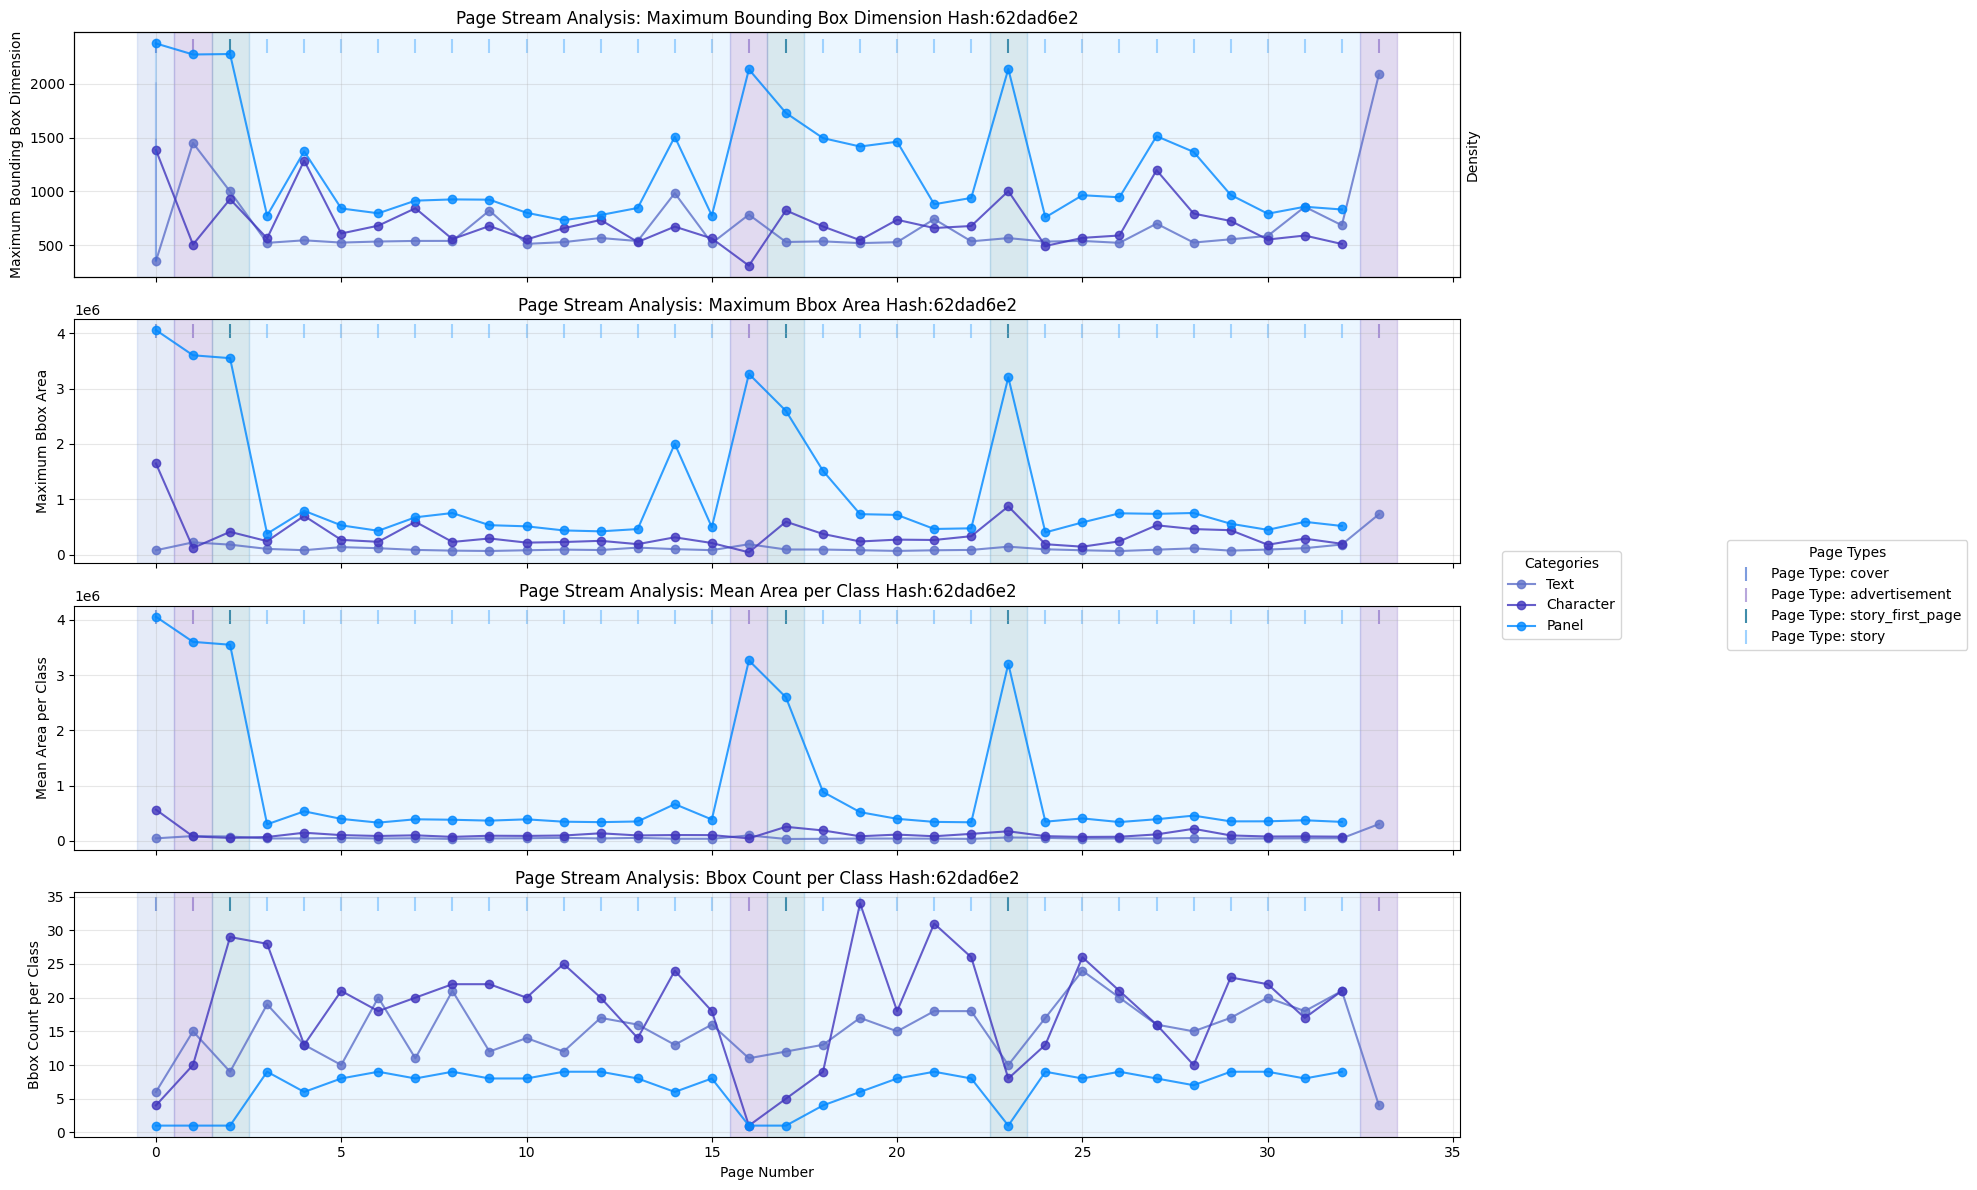

944bdd96


<Figure size 1500x1200 with 0 Axes>

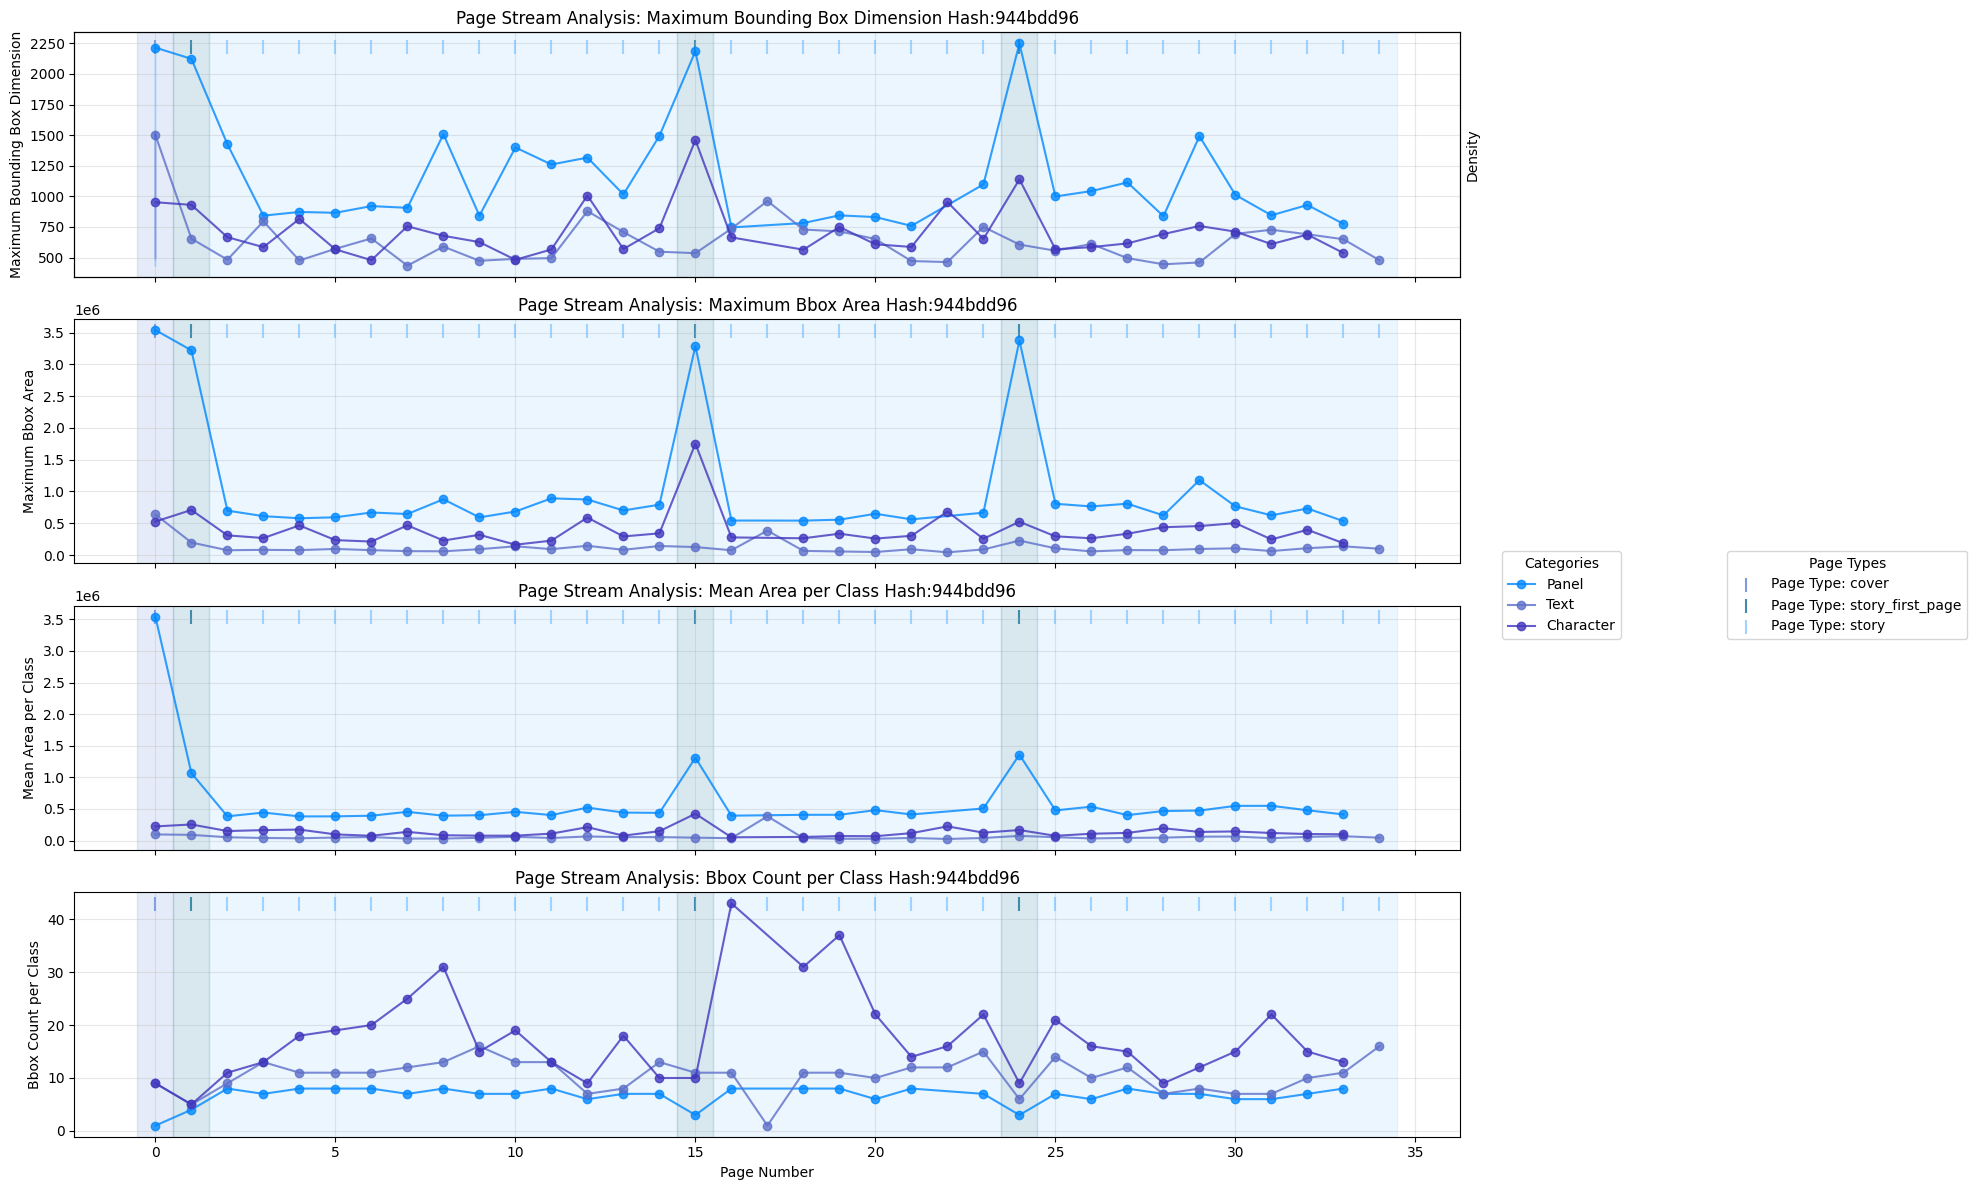

2fd0fd3e


<Figure size 1500x1200 with 0 Axes>

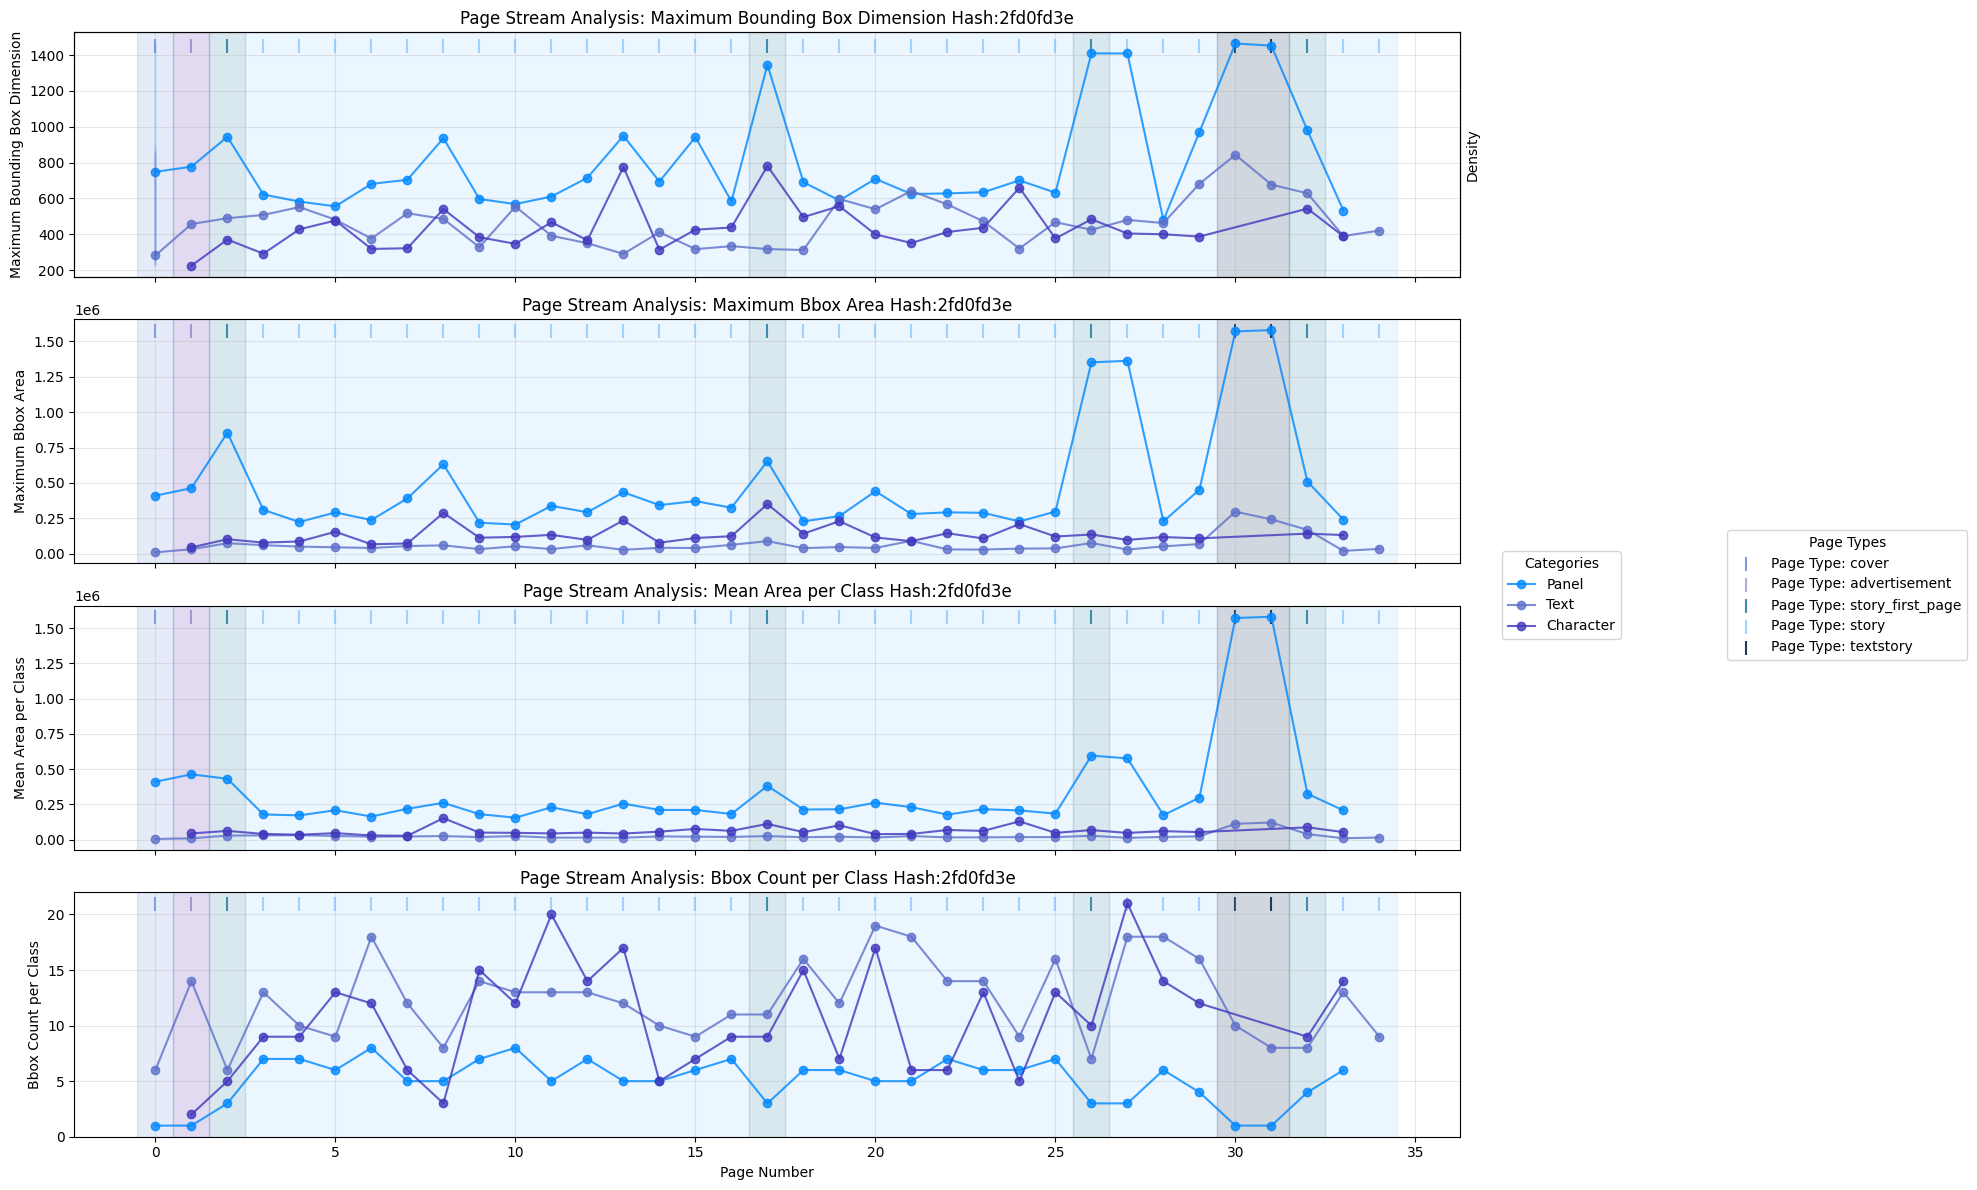

9cfdf10e


<Figure size 1500x1200 with 0 Axes>

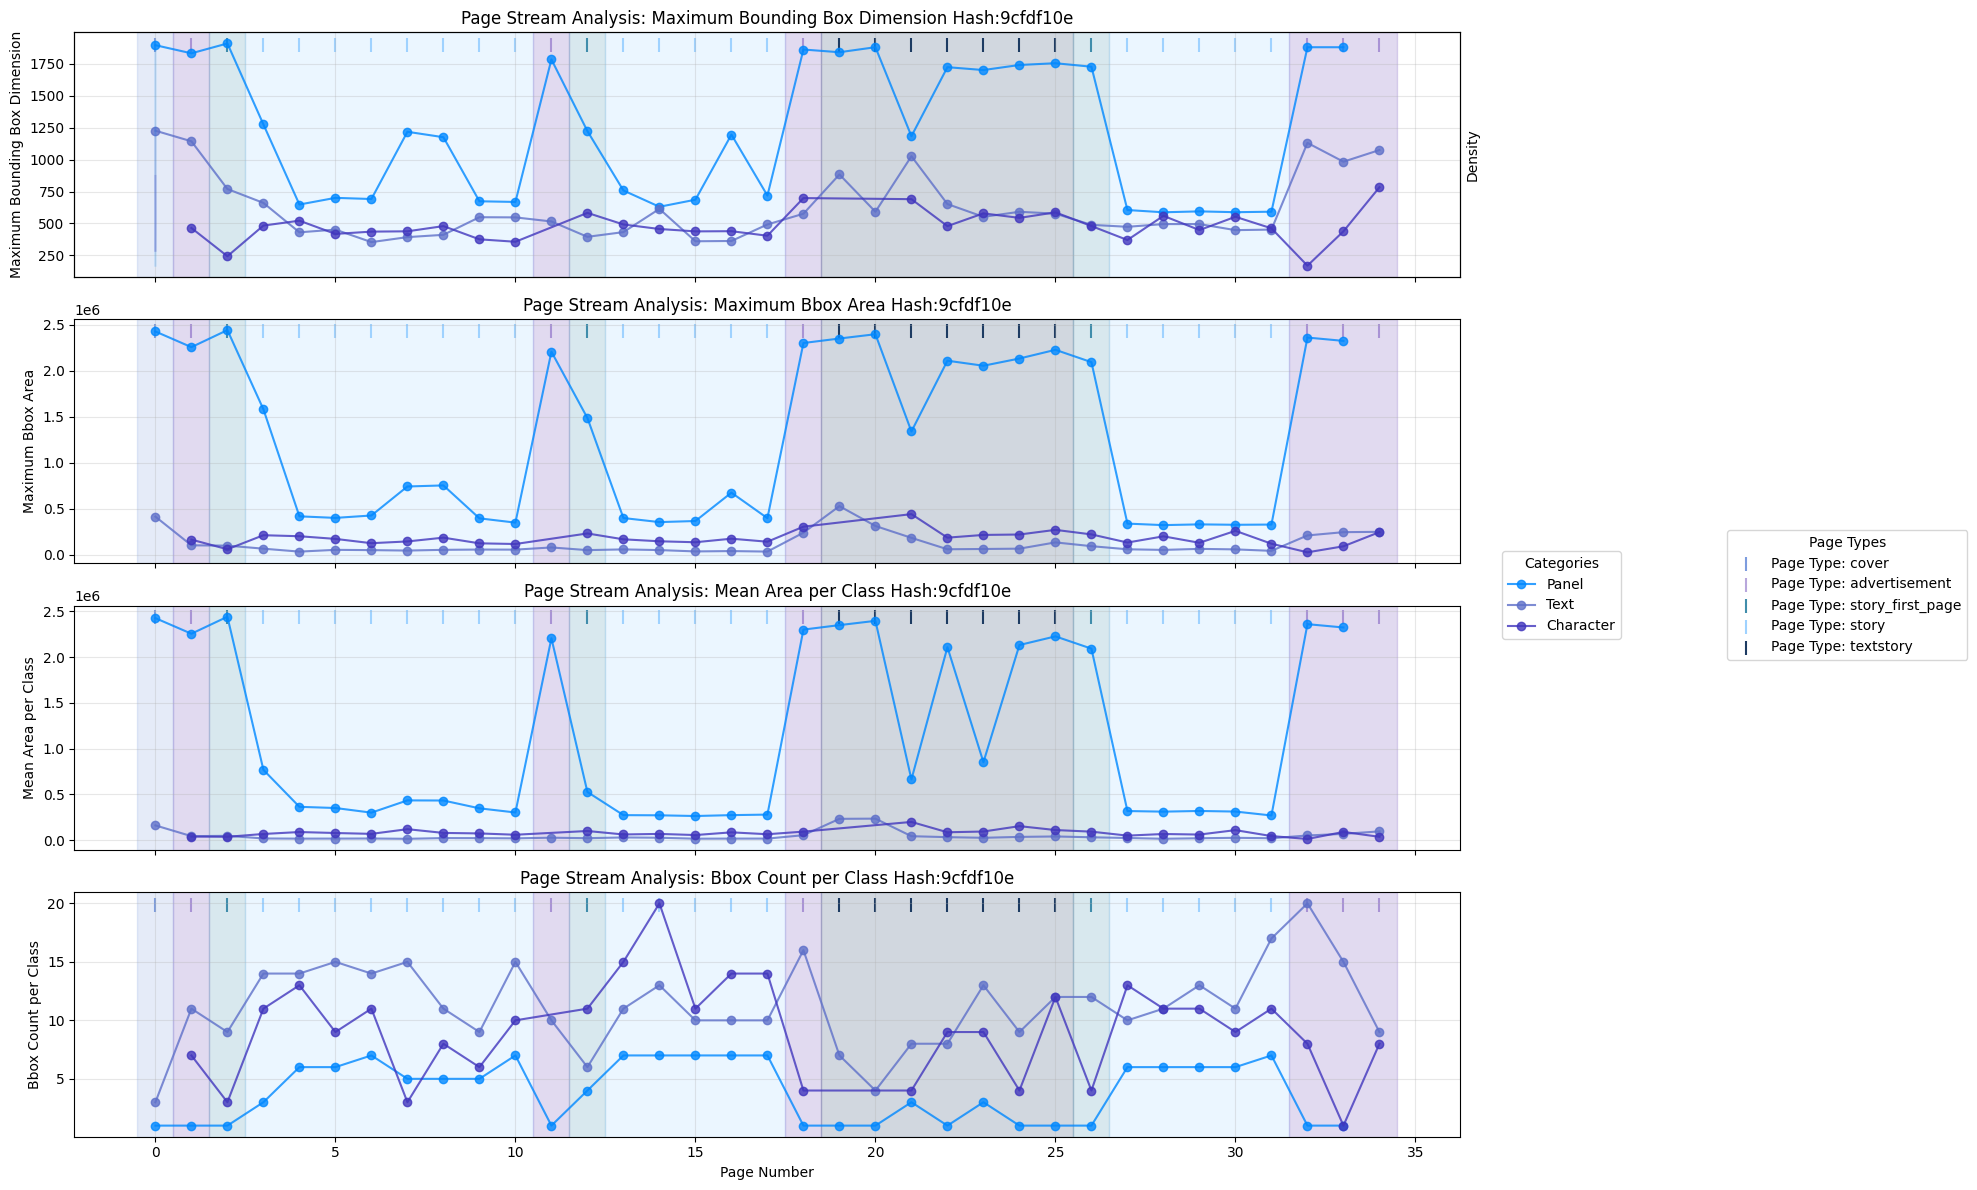

In [16]:
plot_books_stats(page_stats, top_features=None, start=3, end=7)

In [85]:
GT_test = load_GT(GT_path['test'])
results_test = pssa.analyze_comic_book(annots_path['test'], plot=False)

page_stats_test = results_test['page_stats']
annots_df_test = results_test['annotations']
imgs_df_test = results_test['images']

advanced_features_test = pssa.calculate_advanced_features(annots_df_test, imgs_df_test)

page_stats_test = add_page_type_annotations(page_stats_test, annots_df_test, GT_test)

page_to_book = annots_df_test[['page_number', 'book_hash']].drop_duplicates().set_index('page_number')['book_hash']
    
page_stats_test['book_hash'] = page_stats_test['page_number'].map(page_to_book)

In [86]:
train = prepare_data(page_stats, advanced_features)
test = prepare_data(page_stats_test, advanced_features_test)

Original page_stats shape: (43055, 10)
Advanced features shape: (14556, 22)
Transformed shape before merge: (14556, 18)
Final combined shape: (14556, 38)


,page_number,page_number_book,page_type,Panel_bbox_max_dim_max,Panel_bbox_max_dim_mean,Panel_area_max,Panel_area_mean,Panel_bbox_count,Character_bbox_max_dim_max,Character_bbox_max_dim_mean,...,total_character_area,total_text_area,total_face_area,max_panel_centroid_x,max_panel_centroid_y,panel_coverage,text_to_panel_ratio,character_to_text_ratio,max_text_centroid_x,max_text_centroid_y
0,0,10,story,622.137152,470.280935,2.808585e+05,1.684311e+05,6.0,346.430840,285.579688,...,7.156632e+05,153158.236248,0,0.656444,0.812624,0.714754,0.151554,4.672704,0.760299,0.696673
1,1,29,textstory,1253.669985,1253.669985,1.123165e+06,1.123165e+06,1.0,0.000000,0.000000,...,0.000000e+00,668890.470728,0,0.499415,0.487341,0.992809,0.595541,0.000000,0.285136,0.535338
2,2,33,story,927.878781,556.844347,5.246095e+05,2.403284e+05,5.0,379.555623,233.400453,...,3.207928e+05,75726.771253,0,0.505872,0.761459,0.804797,0.063019,4.236187,0.280413,0.600646
3,3,13,story_first_page,1400.462974,1400.462974,1.317045e+06,1.317045e+06,1.0,930.923008,835.185873,...,1.853583e+06,37257.417969,0,0.514935,0.496582,0.931409,0.028289,49.750698,0.402537,0.885681
4,4,44,story,501.600819,468.648540,2.181224e+05,2.034169e+05,6.0,480.155247,266.170843,...,7.973904e+05,129548.439855,0,0.732347,0.790848,0.833751,0.106144,6.155153,0.244183,0.078629


Original page_stats shape: (12314, 10)
Advanced features shape: (4165, 22)
Transformed shape before merge: (4165, 18)
Final combined shape: (4165, 38)


,page_number,page_number_book,page_type,Panel_bbox_max_dim_max,Panel_bbox_max_dim_mean,Panel_area_max,Panel_area_mean,Panel_bbox_count,Character_bbox_max_dim_max,Character_bbox_max_dim_mean,...,total_character_area,total_text_area,total_face_area,max_panel_centroid_x,max_panel_centroid_y,panel_coverage,text_to_panel_ratio,character_to_text_ratio,max_text_centroid_x,max_text_centroid_y
0,0,10,story,943.968697,823.521239,5.144613e+05,469004.729035,8.0,734.156485,359.381148,...,1.461111e+06,690058.185886,0,0.731916,0.145030,0.821950,0.183916,2.117374,0.684015,0.332696
1,1,29,story_first_page,1650.090826,808.493658,1.206061e+06,469499.555347,8.0,561.638242,375.946766,...,1.281643e+06,759409.370025,0,0.496141,0.182957,0.840042,0.202186,1.687684,0.410814,0.142739
2,2,33,story,884.346853,807.632001,6.830424e+05,545176.579144,7.0,682.502195,413.660311,...,2.070770e+06,347085.771052,0,0.753371,0.821709,0.857658,0.090950,5.966161,0.793231,0.399687
3,3,13,story_first_page,1014.669717,816.626352,7.599127e+05,529568.346717,7.0,549.733301,374.920524,...,1.957778e+06,612340.888645,0,0.330376,0.183388,0.814327,0.165186,3.197202,0.331443,0.317778
4,4,44,story,1737.564094,962.805924,1.106169e+06,560694.600337,7.0,763.623357,389.960349,...,2.293815e+06,406252.110128,0,0.495209,0.618816,0.862190,0.103507,5.646285,0.262416,0.306301


In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14383 entries, 0 to 14555
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   page_number                  14383 non-null  int64  
 1   page_number_book             14383 non-null  int64  
 2   page_type                    14383 non-null  object 
 3   Panel_bbox_max_dim_max       14383 non-null  float64
 4   Panel_bbox_max_dim_mean      14383 non-null  float64
 5   Panel_area_max               14383 non-null  float64
 6   Panel_area_mean              14383 non-null  float64
 7   Panel_bbox_count             14383 non-null  float64
 8   Character_bbox_max_dim_max   14383 non-null  float64
 9   Character_bbox_max_dim_mean  14383 non-null  float64
 10  Character_area_max           14383 non-null  float64
 11  Character_area_mean          14383 non-null  float64
 12  Character_bbox_count         14383 non-null  float64
 13  Text_bbox_max_dim_max

In [88]:
def plot_feature_importance(transformed_df, top_n=20):
    df_copy = transformed_df.copy()
    columns_to_drop = ['book_hash', 'page_number', 'page_number_book']
    df_copy = df_copy.drop(columns=[col for col in columns_to_drop if col in df_copy.columns])

    le = LabelEncoder()
    df_copy['page_type_encoded'] = le.fit_transform(df_copy['page_type'])
    df_copy = df_copy.drop(columns=['page_type'])

    correlation = df_copy.corr()['page_type_encoded'].abs().sort_values(ascending=False)
    correlation = correlation[correlation.index != 'page_type_encoded']
    
    correlation = correlation.head(top_n)

    plt.figure(figsize=(14, 10))
    
    ax = sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')
    
    plt.title('Top Features by Correlation with Page Type', fontsize=16)
    plt.xlabel('Absolute Correlation', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    
    for i, v in enumerate(correlation.values):
        ax.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    plt.tight_layout()
    plt.show()
    
    return correlation

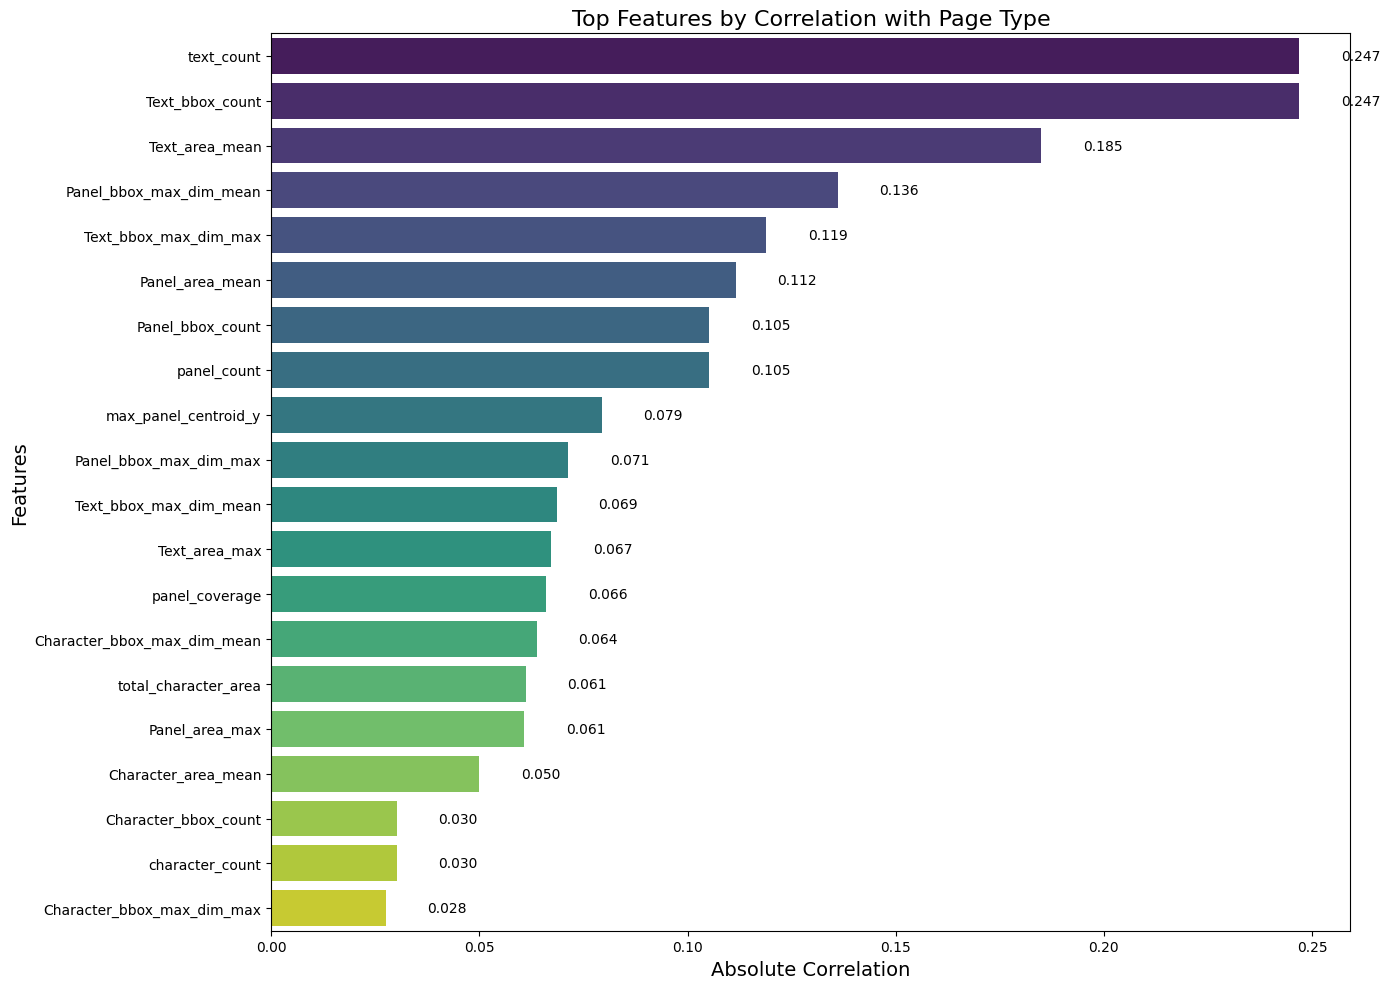

In [89]:
corr = plot_feature_importance(train)

In [90]:
le = LabelEncoder()

X_train = train.drop(['page_number', 'page_number_book', 'page_type', 'book_hash'], axis=1)
y_train = train['page_type']

dump(X_train, 'X_train.joblib')
dump(y_train, 'y_train.joblib')

# y_train_binary = (y_train == 'story').astype(int)
y_train_binary = train['page_type'].isin(['story', 'story_first_page']).astype(int)
y_train_multi = le.fit_transform(y_train)

In [91]:
y_train.value_counts()


page_type
story               10254
story_first_page     1938
advertisement        1254
textstory             600
cover                 337
Name: count, dtype: int64

In [92]:
X_test = test.drop(['page_number', 'page_number_book', 'page_type', 'book_hash'], axis=1)
y_test = test['page_type']

# y_test_binary = (y_test == 'story').astype(int)
y_test_binary = test['page_type'].isin(['story', 'story_first_page']).astype(int)
y_test_multi = le.fit_transform(y_test)

In [93]:
classes_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Class mapping:")
for class_name, encoded_value in classes_mapping.items():
    print(f"  {class_name} → {encoded_value}")

Class mapping:
  advertisement → 0
  cover → 1
  story → 2
  story_first_page → 3
  textstory → 4


In [94]:
param_grids = {
    'logistic': {
        'scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
        'classifier__solver': ['saga', 'liblinear'],
        'classifier__class_weight': ['balanced', None],
        'classifier__max_iter': [1000]
    },
    
    'random_forest': {
        'scaler': [StandardScaler(), 'passthrough'], 
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', 'balanced_subsample', None]
    },
    
    'xgboost': {
        'scaler': [StandardScaler(), 'passthrough'],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__subsample': [0.7, 0.8, 0.9]
    },
    
    'svm': {
        'scaler': [StandardScaler(), RobustScaler()],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
        'classifier__kernel': ['rbf', 'linear', 'poly'],
        'classifier__class_weight': ['balanced', None]
    }
}

## Binary Classification

In [95]:
def cross_validate_models(pipes, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring={'f1_macro': 'f1_macro'}):
    res = []
    for model_name, pipe in pipes.items():
        results = cross_validate(pipe, X, y, cv=cv, scoring=scoring)
        print(f"\n{model_name} Results:")
        for metric in scoring:
            print(f"{metric}: {np.mean(results[f'test_{metric}']):.4f} ± {np.std(results[f'test_{metric}']):.4f}")
        res.append(results)
    return res

def train_models(pipes, X_train, y_train):
    for model_name, pipe in pipes.items():
        print(f'Fitting {model_name}...')
        pipe.fit(X_train, y_train)
    
def plot_confusion_matrix(models, X_test, y_test):
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
    
    if len(models) == 1:
        axes = [axes]
    
    for i, model in enumerate(models):
        model_name = model.named_steps['classifier'].__class__.__name__
        pred = model.predict(X_test)
        cm = confusion_matrix(y_test, pred)
        
        # Normalize the confusion matrix by row (true label)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=['Non-story', 'Story'],
                   yticklabels=['Non-story', 'Story'], ax=axes[i])
        
        axes[i].set_title(f'{model_name} Normalized Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
def grid_search_model(X_train, y_train, model_pipeline, param_grid, cv=5, scoring='f1_macro'):

    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        class_report = classification_report(y_test, y_pred)
        print(class_report)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(y_test, y_prob)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
        
        print(f"\n{name} Test Results:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  ROC AUC:   {roc_auc:.4f}")
    
    return results

def plot_model_comparison(results):
    """Plot comparison of model performance"""
    metrics = list(next(iter(results.values())).keys())
    models = list(results.keys())
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 3*len(metrics)))
    
    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        axes[i].bar(models, values)
        axes[i].set_title(f'{metric.capitalize()}')
        axes[i].set_ylim([0, 1])
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
def plot_learning_curve(estimator, X, y, title=None, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(10, 6))
    
    if title is None:
        if hasattr(estimator, 'named_steps') and 'classifier' in estimator.named_steps:
            title = f"Learning Curves for {estimator.named_steps['classifier'].__class__.__name__}"
        else:
            title = "Learning Curves"
            
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='f1_macro')
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
    
    plt.legend(loc="best")
    return plt

def plot_full_learning_curve(estimator, X, y, title=None, cv=5,
                            n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 15)):
    """
    Plot learning curve with full y-axis range from 0 to 1
    """
    plt.figure(figsize=(12, 8))
    
    if title is None:
        if hasattr(estimator, 'named_steps') and 'classifier' in estimator.named_steps:
            title = f"Learning Curves for {estimator.named_steps['classifier'].__class__.__name__}"
        else:
            title = "Learning Curves"
            
    plt.title(title, fontsize=16)
    plt.ylim([0.0, 1.01])  # Force y-axis to show full range
        
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='f1_macro')
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", linewidth=2, label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", linewidth=2, label="Validation score")
    
    plt.legend(loc="best", fontsize=12)
    
    # Add horizontal lines at important score thresholds
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5)
    
    return plt
        

In [96]:
classes = np.unique(y_train_binary)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_binary)
class_weight_dict = dict(zip(classes, class_weights))

negative_count = sum(y_train_binary == 0)
positive_count = sum(y_train_binary == 1)
scale_pos_weight = negative_count / positive_count if positive_count > 0 else 1.0

# pipes = {
#     'logistic': Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', LogisticRegression(random_state=42, class_weight=class_weight_dict))
#     ]),
    
#     'random_forest': Pipeline([
#         ('scaler', 'passthrough'),
#         ('classifier', RandomForestClassifier(random_state=42, class_weight=class_weight_dict))
#     ]),
    
#     'xgboost': Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight))
#     ]),
    
#     'svm': Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', SVC(random_state=42, probability=True, class_weight=class_weight_dict))
#     ])
# }


# scoring = {
#     'accuracy': 'accuracy',
#     'precision_macro': 'precision_macro',
#     'recall_macro': 'recall_macro',
#     'f1_macro': 'f1_macro',
#     'roc_auc': 'roc_auc'
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# res = cross_validate_models(pipes, X_train, y_train_binary, cv=cv, scoring=scoring)

In [97]:
# best_models = {}

# for model_name, pipeline in pipes.items():
#     print(f"\n{'='*50}")
#     print(f"Tuning {model_name}...")
#     print(f"{'='*50}")
    
#     grid_result = grid_search_model(
#         X_train, 
#         y_train_binary, 
#         pipeline, 
#         param_grids[model_name],
#         cv=cv, 
#         scoring='f1_macro'
#     )
    
#     best_models[model_name] = grid_result.best_estimator_

# dump(best_models, 'best_models.joblib')

In [98]:
best_models = load('best_models.joblib')

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       643
           1       0.97      0.97      0.97      3447

    accuracy                           0.95      4090
   macro avg       0.92      0.91      0.91      4090
weighted avg       0.95      0.95      0.95      4090


logistic Test Results:
  Accuracy:  0.9545
  Precision: 0.9725
  Recall:    0.9736
  F1 Score:  0.9140
  ROC AUC:   0.9812
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       643
           1       0.98      0.99      0.98      3447

    accuracy                           0.97      4090
   macro avg       0.95      0.95      0.95      4090
weighted avg       0.97      0.97      0.97      4090


random_forest Test Results:
  Accuracy:  0.9743
  Precision: 0.9838
  Recall:    0.9858
  F1 Score:  0.9513
  ROC AUC:   0.9900
              precision    recall  f1-score   support

           0       0.86      0.94     

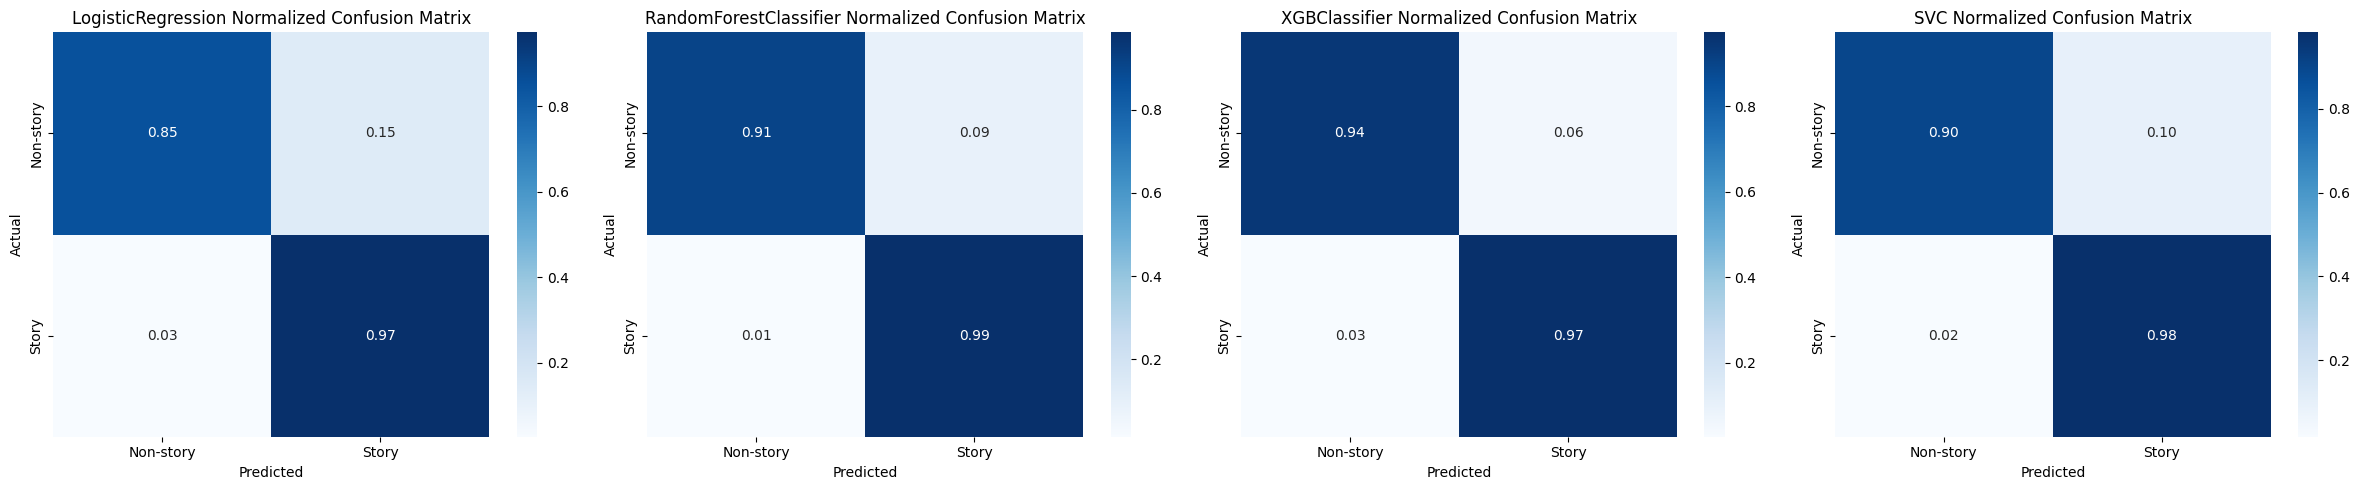

In [99]:
test_results = evaluate_models(best_models, X_test, y_test_binary)

plot_confusion_matrix(list(best_models.values()), X_test, y_test_binary)

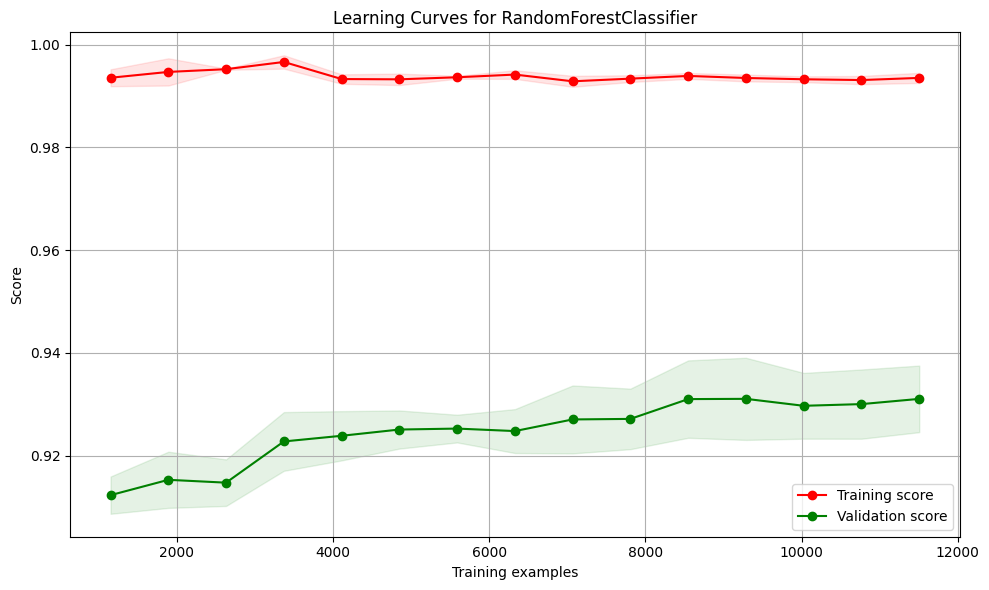

In [100]:
best_model_name = max(test_results, key=lambda x: test_results[x]['f1'])
best_model = best_models[best_model_name]
plot_learning_curve(best_model, X_train, y_train_binary, train_sizes=np.linspace(.1, 1.0, 15))
plt.tight_layout()
plt.show()

In [101]:
params = best_model.named_steps['classifier'].get_params()

print("\nBest model structure:")
print(best_model)
print(params)



Best model structure:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, random_state=42))])
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [102]:
def plot_model_feature_importance(model, feature_names=None, top_n=None):
    importances = model.feature_importances_
    
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(importances))]
    
    indices = np.argsort(importances)[::-1]
    if top_n:
        indices = indices[:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(indices)), importances[indices], color="b", align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

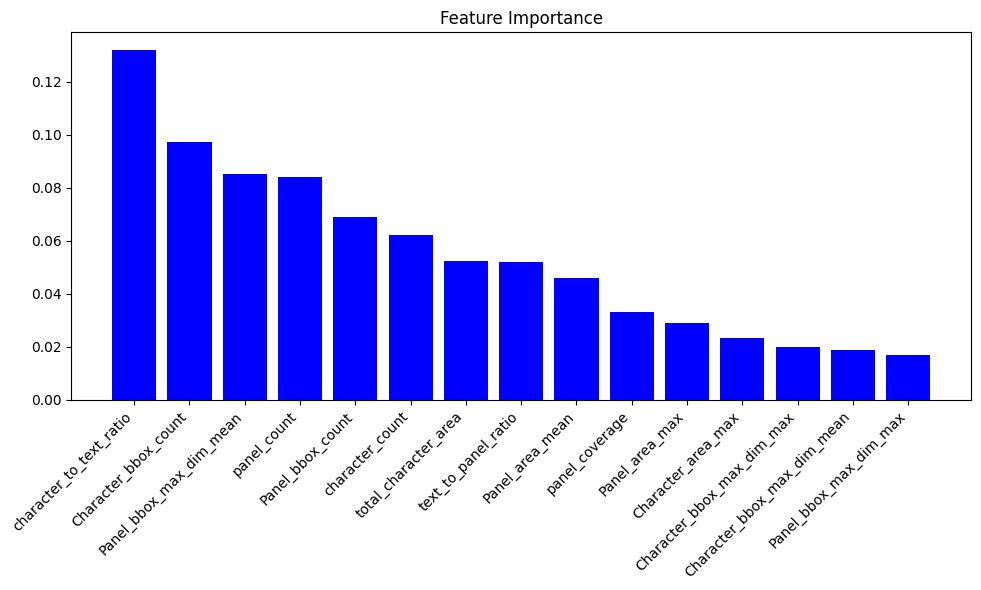

In [103]:
plot_model_feature_importance(best_model.named_steps['classifier'], feature_names=X_train.columns, top_n=15)

In [104]:
def multiclass_evaluate_models(models, X_test, y_test, class_names):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"\n{name} Test Results:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        
        print("\nPer-class metrics:")
        class_report = classification_report(y_test, y_pred, target_names=class_names)
        print(class_report)
    
    return results

def plot_multiclass_confusion_matrix(models, X_test, y_test, class_names):
    fig, axes = plt.subplots(1, len(models), figsize=(7*len(models), 6))
    
    if len(models) == 1:
        axes = [axes]
    
    for i, (model_name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # Normalize the confusion matrix by row (true label)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names, ax=axes[i])
        
        axes[i].set_title(f'{model_name} Normalized Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.tight_layout()
    plt.show()
    
def create_multiclass_pipelines(X_train, y_train):
    
    n_classes = len(np.unique(y_train))
    
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    
    pipes = {
        'logistic': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                random_state=42, 
                multi_class='multinomial',
                solver='lbfgs',
                class_weight=class_weight_dict,
                max_iter=1000
            ))
        ]),
        
        'random_forest': Pipeline([
            ('scaler', 'passthrough'),
            ('classifier', RandomForestClassifier(
                random_state=42, 
                class_weight=class_weight_dict
            ))
        ]),
        
        'xgboost': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', XGBClassifier(
                random_state=42,
                objective='multi:softprob',
                num_class=n_classes
            ))
        ]),
        
        'svm': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC(
                random_state=42,
                probability=True,
                decision_function_shape='ovr',
                class_weight=class_weight_dict
            ))
        ])
    }
    
    return pipes

def plot_model_feature_importance(model, feature_names, top_n=20):
    """
    Plot feature importance for tree-based models with improved formatting.
    
    Args:
        model: Trained model with feature_importances_ attribute
        feature_names: List of feature names
        top_n: Number of top features to plot (default: 20)
    """
    if hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importances = model.named_steps['classifier'].feature_importances_
        else:
            print("Model doesn't have feature_importances_ attribute")
            return
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print("Model doesn't have feature_importances_ attribute")
        return
    
    indices = np.argsort(importances)[::-1]
    if top_n:
        indices = indices[:top_n]

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance", fontsize=16)
    
    y_pos = np.arange(len(indices))
    plt.barh(y_pos, importances[indices], align='center', color='skyblue')
    
    plt.yticks(y_pos, [feature_names[i] for i in indices])
    
    for i, v in enumerate(importances[indices]):
        plt.text(v + 0.001, i, f"{v:.3f}", va='center')
    
    plt.xlabel("Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

In [105]:
# multiclass_pipes = create_multiclass_pipelines(X_train, y_train_multi)

print("Cross-validating multiclass models...")
# multiclass_cv_results = cross_validate_models(multiclass_pipes, X_train, y_train_multi, 
#                                              scoring=scoring)


Cross-validating multiclass models...


In [106]:
# best_models_multi = {}

# for model_name, pipeline in multiclass_pipes.items():
#     print(f"\n{'='*50}")
#     print(f"Tuning {model_name}...")
#     print(f"{'='*50}")
    
#     grid_result = grid_search_model(
#         X_train, 
#         y_train_multi, 
#         pipeline, 
#         param_grids[model_name],
#         cv=cv, 
#         scoring='f1_macro'
#     )
    
#     best_models_multi[model_name] = grid_result.best_estimator_

# dump(best_models_multi, 'best_models_multi.joblib')

In [107]:
best_models_multi = load('best_models_multi.joblib')


logistic Test Results:
  Accuracy:  0.8848
  Precision: 0.8131
  Recall:    0.7827
  F1 Score:  0.7875

Per-class metrics:
                  precision    recall  f1-score   support

   advertisement       0.81      0.84      0.83       394
           cover       0.66      0.80      0.72        94
           story       0.91      0.98      0.94      2870
story_first_page       0.82      0.48      0.61       577
       textstory       0.86      0.81      0.84       155

        accuracy                           0.88      4090
       macro avg       0.81      0.78      0.79      4090
    weighted avg       0.88      0.88      0.88      4090


random_forest Test Results:
  Accuracy:  0.8968
  Precision: 0.8286
  Recall:    0.8024
  F1 Score:  0.8125

Per-class metrics:
                  precision    recall  f1-score   support

   advertisement       0.86      0.84      0.85       394
           cover       0.71      0.77      0.74        94
           story       0.93      0.97      0.95

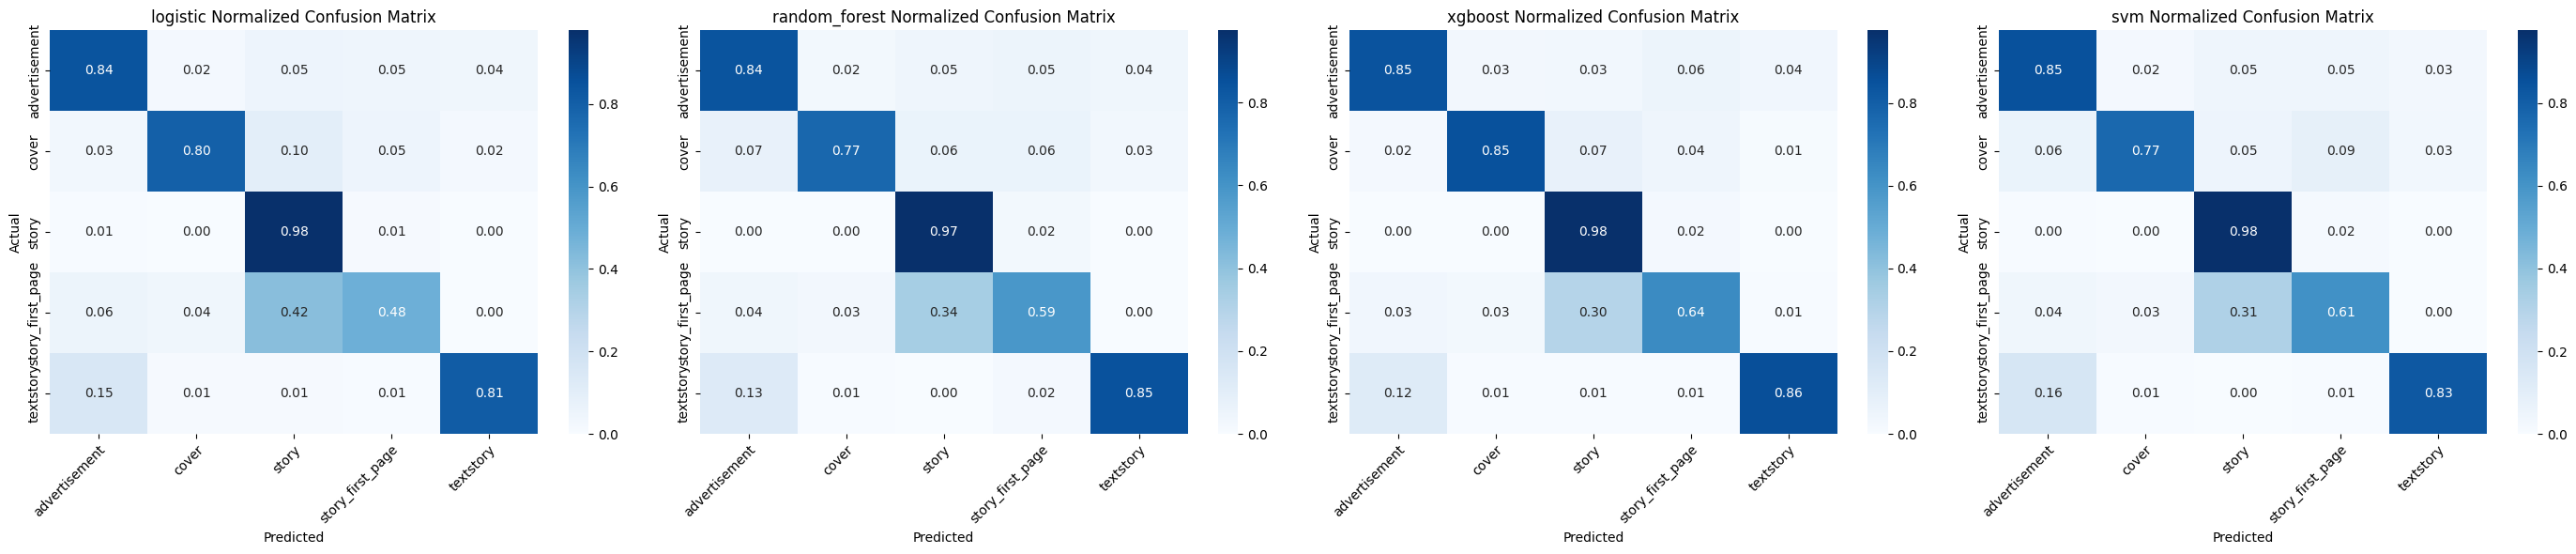

In [108]:
# train_models(best_models_multi, X_train, y_train_multi)

class_names = list(le.classes_)
multiclass_test_results = multiclass_evaluate_models(best_models_multi, X_test, y_test_multi, class_names)

plot_multiclass_confusion_matrix(best_models_multi, X_test, y_test_multi, class_names)